<a href="https://colab.research.google.com/github/SammyGbabs/Sound-Clustering/blob/main/SamuelBabs_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
#Make allNecessary Imports
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/unlabelled_sounds.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
# Load the Data
unlabelled_data_path = '/content/unlabelled_sounds'

# Load audio files
audio_files = [f for f in os.listdir(unlabelled_data_path) if f.endswith('.wav')]

# Print first few files
print("Number of audio files:", len(audio_files))
print("First 5 files:", audio_files[:5])

Number of audio files: 3000
First 5 files: ['540.wav', '1480.wav', '1853.wav', '1691.wav', '1924.wav']


In [4]:
def extract_features(file_path):
    """Extracts Mel Spectrogram features from an audio file."""
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # Compute Mel Spectrogram
    mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale (dB)

    # Extract statistical features
    feature_vector = np.hstack((
        np.mean(mel_db, axis=1),  # Mean of each frequency bin
        np.std(mel_db, axis=1)    # Standard deviation of each frequency bin
    ))

    return feature_vector

# Extract features from all audio files
features = []
file_names = []

for file in os.listdir(unlabelled_data_path):
    file_path = os.path.join(unlabelled_data_path, file)
    if file.endswith('.wav'):
        feature_vector = extract_features(file_path)
        features.append(feature_vector)
        file_names.append(file)

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df.insert(0, "file_name", file_names)  # Add file names for reference

# Display extracted features
print("Extracted Features Shape:", features_df.shape)
features_df.head()


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1259
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1868
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1880
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

Extracted Features Shape: (3000, 257)


,file_name,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,540.wav,-44.838188,-40.438408,-41.444202,-43.011627,-24.584564,-8.271156,-10.247986,-26.354641,-31.876394,...,7.803632,9.769224,9.265806,9.323468,8.747928,7.415126,6.514438,5.112753,3.998931,4.115188
1,1480.wav,-23.487692,-38.874241,-40.124504,-42.662933,-39.302002,-20.432261,-17.473867,-24.434689,-34.072701,...,2.989405,3.046111,2.292455,1.345475,1.105718,0.797465,1.593508,1.226362,1.814917,3.231967
2,1853.wav,-71.235245,-75.569435,-75.413940,-75.118080,-72.892326,-57.595863,-51.595001,-27.095648,-18.092617,...,9.325812,9.777923,8.246059,5.771050,5.739445,6.532806,5.584820,5.335244,5.376517,3.193168
3,1691.wav,-42.412022,-42.844883,-41.982098,-47.086613,-43.129700,-29.994036,-16.528036,-4.809103,-8.166613,...,1.997272,3.824848,2.912915,1.398640,1.671154,1.507183,2.152516,2.038006,2.406387,0.577025
4,1924.wav,-79.034920,-70.910522,-63.470764,-54.498993,-40.543350,-27.948435,-25.352228,-41.254406,-42.845551,...,9.188017,7.685497,7.689011,8.767777,8.079054,7.716350,6.630808,6.055474,5.739293,5.273378


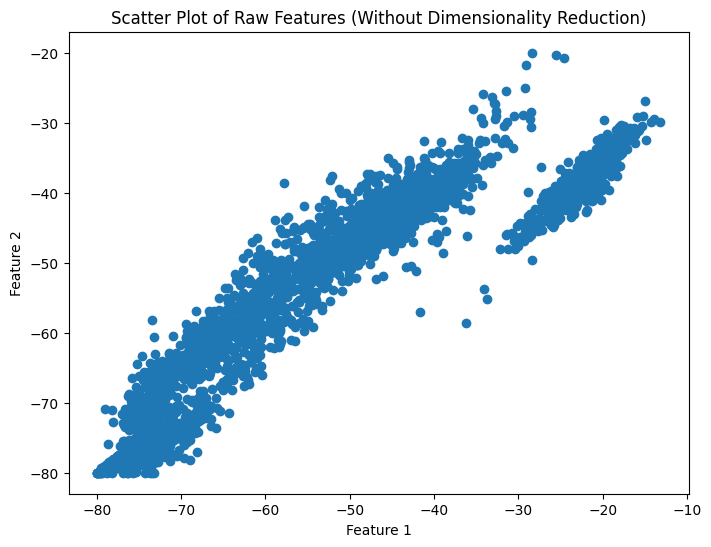

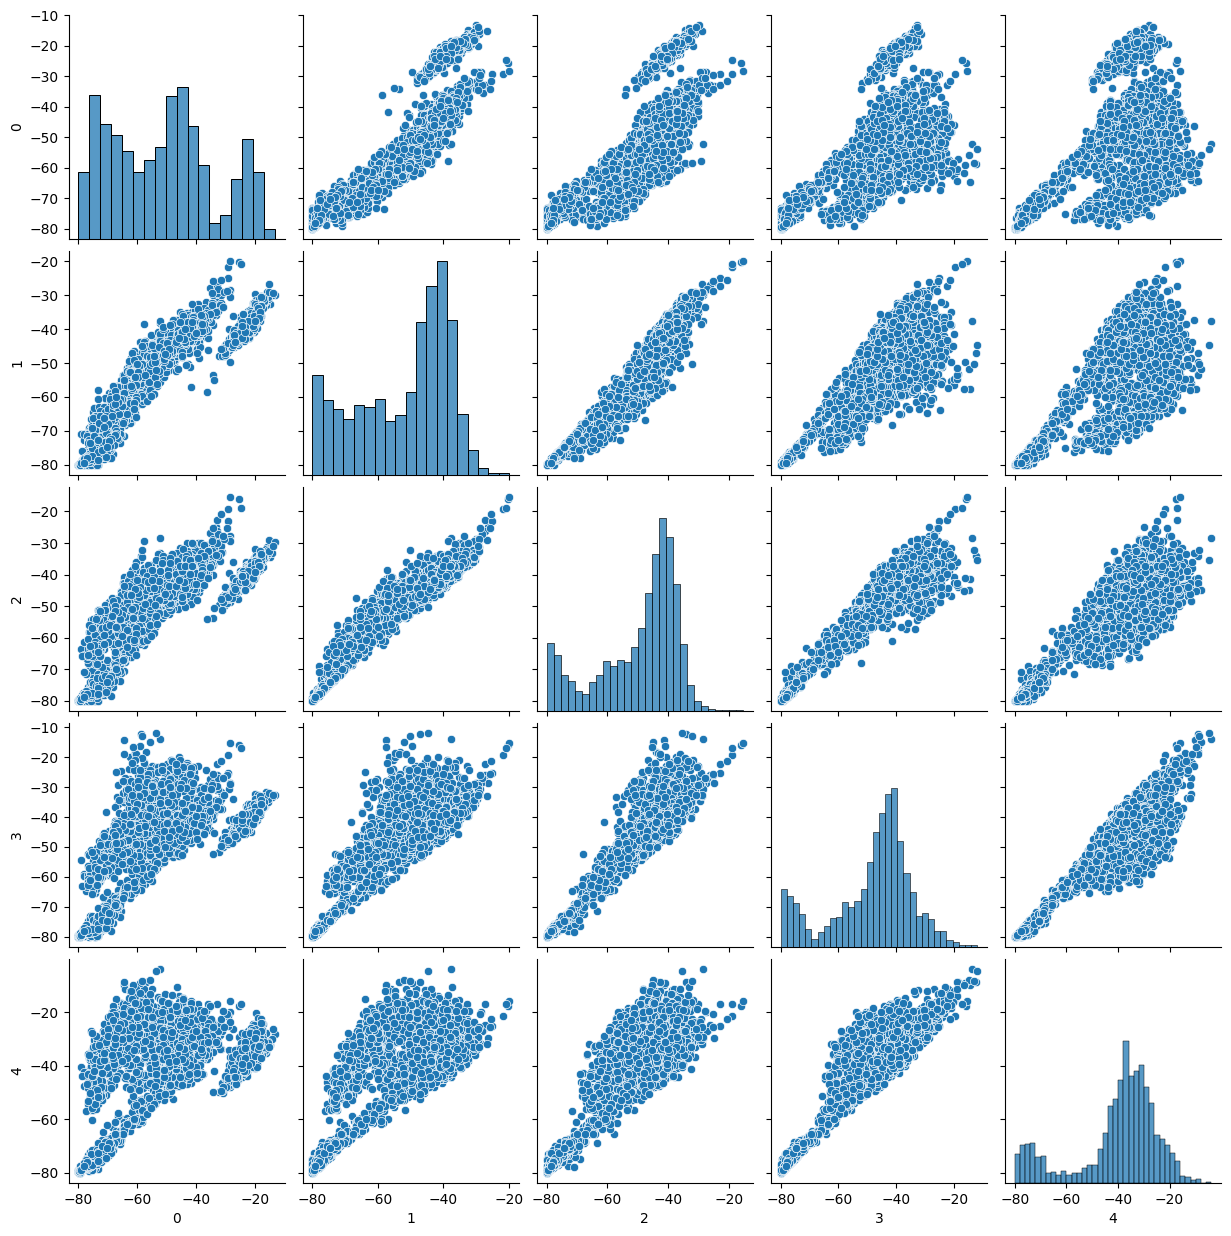

In [5]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(x=features_df.iloc[:, 1], y=features_df.iloc[:, 2])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = features_df.iloc[:, 1:6]
sns.pairplot(df)
plt.show()


### Why is dimensionality reduction important?
Dimensionality reduction is important because it helps address the challenges that arise when working with high-dimensional data. During the visualization of extracted features, one key issue encountered was the difficulty in representing all relationships clearly in 2D scatter plots. The presence of overlapping data points made it hard to identify distinct clusters, and some projections appeared cluttered, making interpretation challenging. This problem highlights the necessity of reducing the number of dimensions while retaining the most relevant information.  

In addition, high-dimensional data often contain redundant or correlated features that do not significantly contribute to the clustering process. As observed in the visualization, the scatter plots suggest some structure in the data, with visible patterns where points are more concentrated, indicating correlations between features. By applying dimensionality reduction techniques such as PCA or t-SNE, we can extract the most meaningful components, enhancing both visualization and clustering performance. This reduction also improves computational efficiency, making it easier to process and analyze large datasets.  

Furthermore, while extracting features, I encountered warnings such as `/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1639`. These warnings indicate that the chosen FFT window size was too large for some of the sound files, leading to potential distortions in feature extraction. This further emphasizes the need for dimensionality reduction, as some extracted features may be unreliable due to such inconsistencies. By reducing dimensions, we can focus on the most essential aspects of the data, mitigating the effects of these extraction issues and improving the overall clustering quality.

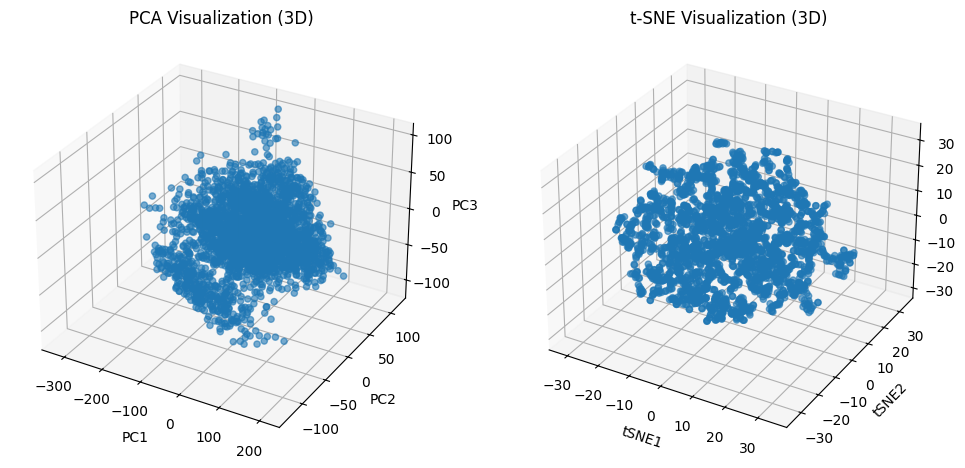

In [6]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=5, random_state=42)

# Convert features to a NumPy array
features_array = np.array(features)
features_tsne = tsne.fit_transform(features_array) # Pass the NumPy array to fit_transform
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization goes here
# 3D Visualization for t-SNE
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.6)
ax1.set_title('PCA Visualization (3D)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# 3D Visualization for t-SNE
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.6)
ax2.set_title('t-SNE Visualization (3D)')
ax2.set_xlabel('tSNE1')
ax2.set_ylabel('tSNE2')
ax2.set_zlabel('tSNE3')

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
Based on the visualizations:  

### **Comparison of PCA and t-SNE for Cluster Separability**  

1. **PCA Visualization**  
   - PCA reduces dimensionality by preserving the variance in the data.  
   - The points appear spread out, but there is no clear cluster separation.  
   - PCA is linear, meaning it does not capture complex non-linear structures.  

2. **t-SNE Visualization**  
   - t-SNE is a non-linear dimensionality reduction method, often better at preserving local structures.  
   - The t-SNE plot shows more compact groups, suggesting better separation of clusters.  
   - However, t-SNE can sometimes distort global relationships, making interpretation challenging.  

### **Which Method Provides Better Separability?**  
- **t-SNE provides better separability** because it captures local structures more effectively.  
- The PCA plot appears more dispersed, indicating that linear methods may not be sufficient for complex data distributions.  
- If the goal is to identify clusters, t-SNE is the better choice. However, PCA remains useful for interpretability and understanding overall variance.

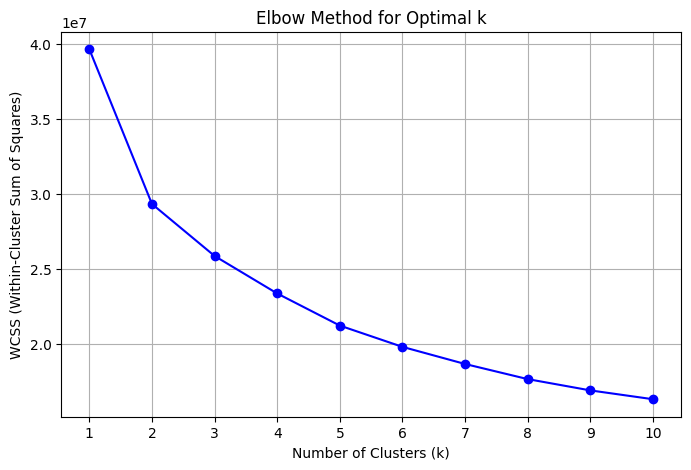

In [7]:
# Optimize number of clusters using Elbow Method
# Define a range of cluster values to test
wcss = []  # Within-cluster sum of squares
k_values = range(1, 11)  # Testing k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)  # Inertia: sum of squared distances to the closest cluster center

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

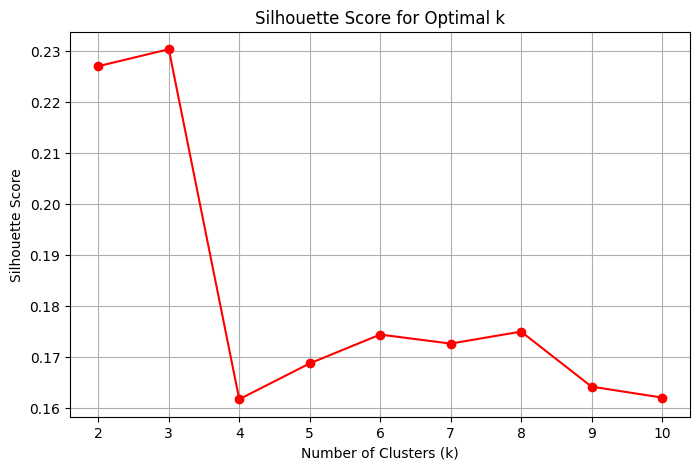

Optimal number of clusters (k) based on Silhouette Score: 3


In [8]:
# Optimize number of clusters using  Silhouette Score
silhouette_scores = []

for k in range(2, 11):  # Start from k=2 (since k=1 has no clusters to compare)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    score = silhouette_score(features, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Find the best k with highest silhouette score
optimal_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters (k) based on Silhouette Score: {optimal_k}')

**NOTE: Since t-SNE provides better separability because it captures local structures more effectivel, I will be using the t-SNE to plot my K-means and dbScan visualization.**

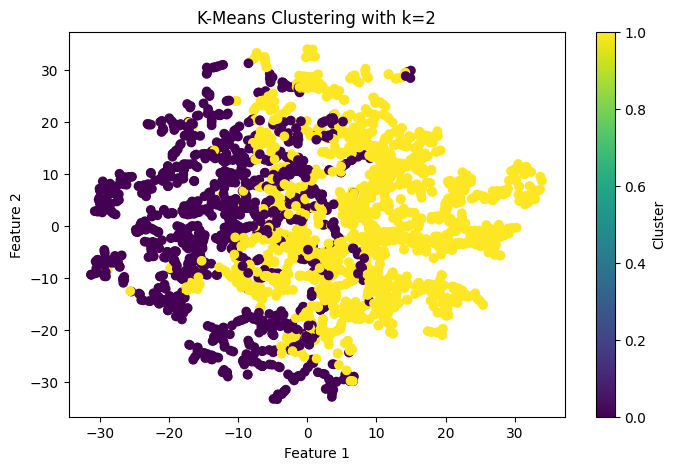

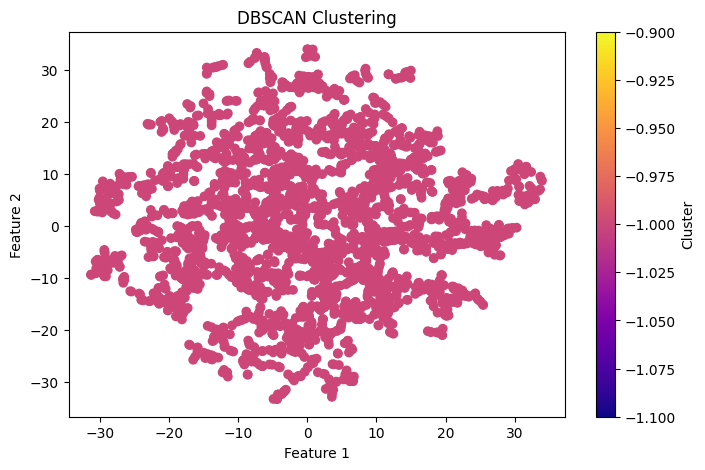

In [16]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'K-Means Clustering with k={optimal_k}')
plt.colorbar(label='Cluster')
plt.grid(False)
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='plasma', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.grid(False)
plt.show()


In [19]:
# Evaluate K-Means clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)
kmeans_inertia = kmeans.inertia_  # Sum of squared distances to cluster centers (Elbow method metric)

# Evaluate DBSCAN clustering (Only if DBSCAN forms more than one cluster)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print evaluation metrics
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}, Inertia: {kmeans_inertia:.4f}")

if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.2269, Davies-Bouldin Index: 1.6356, Inertia: 29322746.0000
DBSCAN failed to form meaningful clusters.


# **Tweaking the Parameters (eps, and min_samles) of dbScan to see if there can be improvements**

In [20]:
# Define a range of eps and min_samples values to test
eps_values = np.arange(1, 10, 1)  # Testing eps from 1 to 10
min_samples_values = [2, 3, 5, 10]  # Testing different min_samples values

best_eps = None
best_min_samples = None
best_silhouette = -1  # Start with the lowest possible silhouette score

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(features_array)

        # Only evaluate if DBSCAN creates more than 1 cluster
        if len(set(dbscan_labels)) > 1:
            silhouette = silhouette_score(features_array, dbscan_labels)
            db_index = davies_bouldin_score(features_array, dbscan_labels)

            print(f"DBSCAN - eps: {eps}, min_samples: {min_samples}, Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {db_index:.4f}")

            # Track the best performing parameters
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples

# Print best parameters
if best_eps is not None:
    print(f"\nBest DBSCAN parameters: eps = {best_eps}, min_samples = {best_min_samples}, Silhouette Score = {best_silhouette:.4f}")
else:
    print("DBSCAN still did not form meaningful clusters.")


DBSCAN still did not form meaningful clusters.


### Discuss the results (max 5 lines)
**K-Means** performed better than **DBSCAN**, achieving a **Silhouette Score of 0.2269** indicating a weak but existing clustering structure and a **Davies-Bouldin Index of 1.6356**, indicating moderate/Average clustering quality. **DBSCAN failed to form meaningful clusters**, even after tweaking **eps** and **min_samples**, suggesting that the dataset lacks the density variations DBSCAN relies on and also indicating bad clustering quality. Since **dimensionality reduction** was already applied, the issue likely lies in the nature of the data itself. **K-Means remains the better method** for this dataset, though further fine-tuning or alternative clustering techniques may improve results.

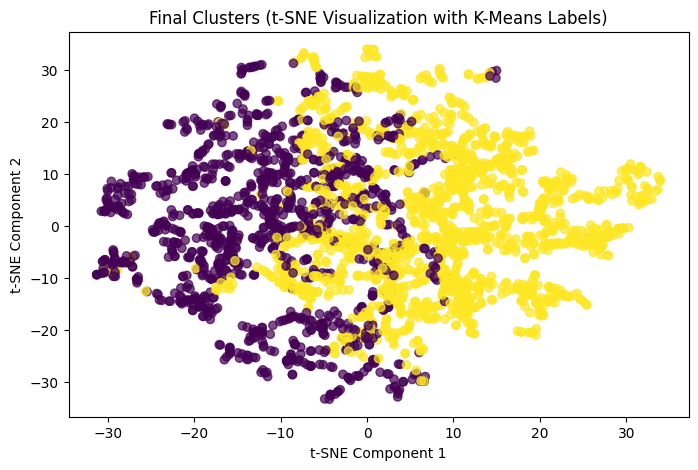

In [18]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.


### **Final Analysis**  

Dimensionality reduction helped in clustering by simplifying the dataset while preserving its essential structure. Techniques like **PCA** and **t-SNE** allowed us to visualize the data more effectively and removed redundant information, making it easier for K-Means to identify patterns. However, despite applying dimensionality reduction, **DBSCAN still failed to form meaningful clusters**, suggesting that the dataset lacks the density-based structure DBSCAN relies on. This indicates that reducing dimensions alone is not always enough—other factors, such as feature scaling and distribution, also impact clustering effectiveness.  

In this scenario, **t-SNE outperformed PCA** in terms of separability, as its visualization displayed clearer, more distinct clusters. This suggests that t-SNE was better at capturing the local structures and non-linear relationships in the data, making it more useful for interpreting cluster distributions.  

**K-Means performed better** because it assumes spherical clusters and assigns each point to the nearest centroid, which aligned better with the dataset’s structure. Its **Silhouette Score of 0.2269** and **Davies-Bouldin Index of 1.6356** suggest moderate cluster separation, while **DBSCAN was unsuccessful** even after tuning parameters like `eps` and `min_samples`. This highlights that K-Means is more robust when clusters are relatively well-separated, whereas DBSCAN struggles when data lacks distinct density variations.  

In real-world clustering challenges, such as **speech or sound classification**, datasets often contain overlapping classes or varying densities, making clustering difficult. The results here reflect a common issue: **some clustering methods work well on structured data but fail on complex distributions.** This experiment reinforces the importance of choosing the right clustering algorithm based on data characteristics rather than applying a one-size-fits-all approach.